In [1]:
import tensorflow as tf
import os

print(tf.__version__)

2.0.0


In [2]:
from tensorflow.keras import layers,activations

# 自定义残差层
class Residual(tf.keras.layers.Layer):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super().__init__()
        self.conv1 = layers.Conv2D(num_channels,
                                   padding='same',
                                   kernel_size=3,
                                   strides=strides)
        self.conv2 = layers.Conv2D(num_channels, kernel_size=3,padding='same')
        if use_1x1conv:
            # 输入和输出的通道数不同时，不能用来相加，所以使用 1 * 1 的卷积进行调整
            self.conv3 = layers.Conv2D(num_channels,
                                       kernel_size=1,
                                       strides=strides)
        else:
            self.conv3 = None
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, X):
        Y = activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return activations.relu(Y + X)

In [3]:
blk = Residual(3)
#tensorflow input shpe     (n_images, x_shape, y_shape, channels).
X = tf.random.uniform((4, 6, 6 , 3))
blk(X).shape#TensorShape([4, 6, 6, 3])

TensorShape([4, 6, 6, 3])

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape
#TensorShape([4, 3, 3, 6])

TensorShape([4, 3, 3, 6])

In [5]:
# 构建残差层
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self,num_channels, num_residuals, first_block=False,**kwargs):
        # num_channels, num_residuals 分别为 输出通道数和残差层数
        super(ResnetBlock, self).__init__(**kwargs)
        self.Layers=[]
        for i in range(num_residuals):
            if i == 0 and not first_block:
                # strides=2，因为padding='same'，即图片尺寸减到 1 / 2
                self.Layers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.Layers.append(Residual(num_channels))      

    def call(self, X):
        for layer in self.Layers:
            X = layer(X)
        return X

In [6]:
class ResNet(tf.keras.Model):
    def __init__(self,num_blocks,**kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.conv=layers.Conv2D(64, kernel_size=7, strides=2, padding='same')
        self.bn=layers.BatchNormalization()
        self.relu=layers.Activation('relu')
        self.mp=layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        self.resnet_block1=ResnetBlock(64,num_blocks[0], first_block=True)
        self.resnet_block2=ResnetBlock(128,num_blocks[1])
        self.resnet_block3=ResnetBlock(256,num_blocks[2])
        self.resnet_block4=ResnetBlock(512,num_blocks[3])
        self.gap=layers.GlobalAvgPool2D()
        self.fc=layers.Dense(units=10,activation=tf.keras.activations.softmax)

    def call(self, x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.mp(x)
        x=self.resnet_block1(x)
        x=self.resnet_block2(x)
        x=self.resnet_block3(x)
        x=self.resnet_block4(x)
        x=self.gap(x)
        x=self.fc(x)
        return x

In [7]:
# 简单测试一下
mynet=ResNet([2,2,2,2])

X = tf.random.uniform(shape=(1,  224, 224 , 1))
for layer in mynet.layers:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv2d_5 output shape:	 (1, 112, 112, 64)
batch_normalization_4 output shape:	 (1, 112, 112, 64)
activation output shape:	 (1, 112, 112, 64)
max_pooling2d output shape:	 (1, 56, 56, 64)
resnet_block output shape:	 (1, 56, 56, 64)
resnet_block_1 output shape:	 (1, 28, 28, 128)
resnet_block_2 output shape:	 (1, 14, 14, 256)
resnet_block_3 output shape:	 (1, 7, 7, 512)
global_average_pooling2d output shape:	 (1, 512)
dense output shape:	 (1, 10)


In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((10000, 28, 28, 1)).astype('float32') / 255

mynet.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = mynet.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)

test_scores = mynet.evaluate(x_test, y_test, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 17s 346us/sample - loss: 0.4795 - accuracy: 0.8301 - val_loss: 0.4205 - val_accuracy: 0.8532
Epoch 2/5
48000/48000 [==============================] - 14s 291us/sample - loss: 0.3261 - accuracy: 0.8809 - val_loss: 0.3999 - val_accuracy: 0.8468
Epoch 3/5
48000/48000 [==============================] - 14s 292us/sample - loss: 0.2838 - accuracy: 0.8959 - val_loss: 0.3252 - val_accuracy: 0.8787
Epoch 4/5
48000/48000 [==============================] - 14s 292us/sample - loss: 0.2605 - accuracy: 0.9022 - val_loss: 0.2886 - val_accuracy: 0.8952
Epoch 5/5
48000/48000 [==============================] - 14s 291us/sample - loss: 0.2417 - accuracy: 0.9105 - val_loss: 0.2876 - val_accuracy: 0.8992
10000/1 - 2s - loss: 0.2410 - accuracy: 0.8950


conv2d_5 itput shape:	 (1, 28, 28, 1)
conv2d_5 output shape:	 (1, 14, 14, 64)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
batch_normalization_4 itput shape:	 (1, 14, 14, 64)
batch_normalization_4 output shape:	 (1, 14, 14, 64)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
activation itput shape:	 (1, 14, 14, 64)
activation output shape:	 (1, 14, 14, 64)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
max_pooling2d itput shape:	 (1, 14, 14, 64)
max_pooling2d output shape:	 (1, 7, 7, 64)
(7, 7)
(7, 7)
(7, 7)
(7, 7)
resnet_block itput shape:	 (1, 7, 7, 64)
resnet_block output shape:	 (1, 7, 7, 64)
(7, 7)
(7, 7)
(7, 7)
(7, 7)
resnet_block_1 itput shape:	 (1, 7, 7, 64)
resnet_block_1 output shape:	 (1, 4, 4, 128)
(4, 4)
(4, 4)
(4, 4)
(4, 4)
resnet_block_2 itput shape:	 (1, 4, 4, 128)
resnet_block_2 output shape:	 (1, 2, 2, 256)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
resnet_block_3 itput shape:	 (1, 2, 2, 256)
resnet_block_3 output shape:	 (1, 1, 1, 512)
(1, 1)
(1, 1)
(1, 1)
(1, 1)


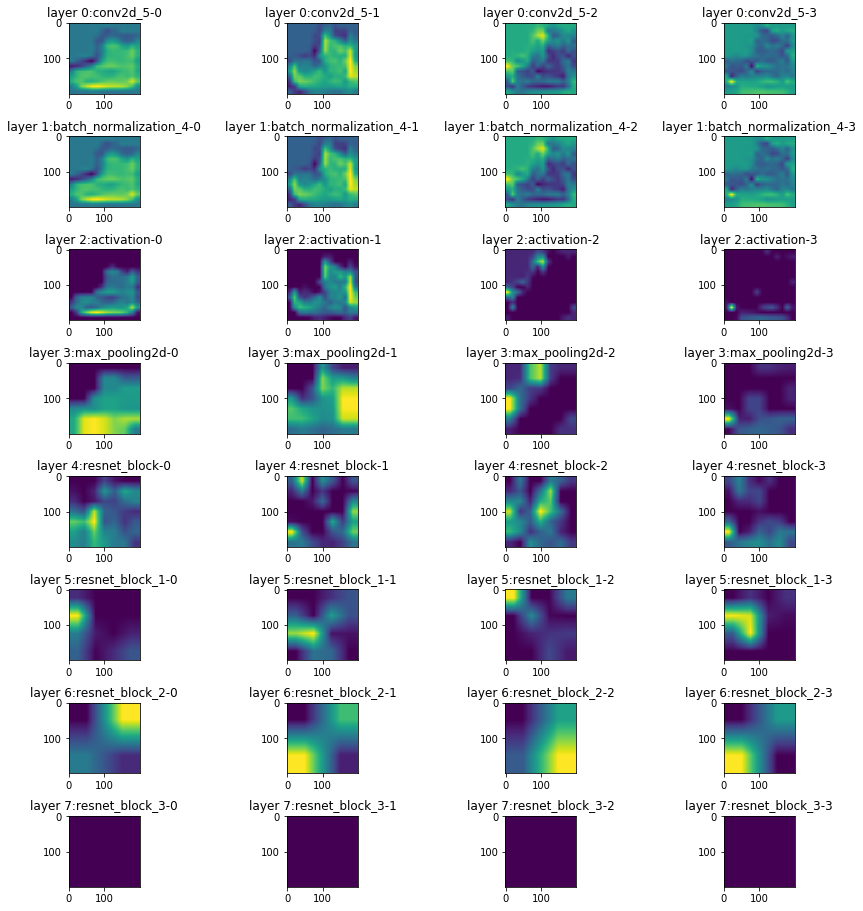

In [13]:
import matplotlib.pyplot as plt
# 展示其中的前八层的特征图
X = x_train[0]

def show(X, k,i, name):
    print(X.shape)
    X = tf.expand_dims(X, axis=-1)
    # 将每个图转换为 200 * 200的像素，但这个不是图大小
    X = tf.image.resize(X,  [200,200], method='bilinear')
    X_ = tf.squeeze(X)
    t = plt.subplot(8, 4,  4*k + i + 1)
    t.title.set_text('layer %s:'%k + name + '-' + str(i))
    plt.imshow(X_)


X = tf.expand_dims(X, axis=0)

# 设置图纸大小
plt.figure(figsize=(15, 15))
# 打印前 8 层的部分特征图
for k,blk in enumerate(mynet.layers[0:8]):
    print(blk.name,'itput shape:\t',X.shape)
#     show(X[0,:,:,0])
    X = blk(X)

    print(blk.name, 'output shape:\t', X.shape)
    # 选择其中的四个通道
    for i in range(4):
        show(X[0,:,:,i], k, i, blk.name)
# 调整子图的间隔
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots,
               # expressed as a fraction of the average axis width
hspace = 0.6   # the amount of height reserved for white space between subplots,
               # expressed as a fraction of the average axis height

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top,
                wspace=wspace, hspace=hspace)


plt.show()

In [14]:
mynet.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            multiple                  3200      
_________________________________________________________________
batch_normalization_4 (Batch multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
resnet_block (ResnetBlock)   multiple                  148736    
_________________________________________________________________
resnet_block_1 (ResnetBlock) multiple                  526976    
_________________________________________________________________
resnet_block_2 (ResnetBlock) multiple                  2102